# May 28, 2022: Create MAX dataset
simple block design paradigm to study anxious apprehension by contrasting threat and touch conditions.
threat is painful electrical stimulation and touch is a mild electric vibration.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions

True


2022-05-28 15:18:19.380922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def get_stim_file(subj, name):
    if len(runs_to_exclude[runs_to_exclude.Subject == subj].values) == 0:
        stim_path = f"{main_data_path}/stim_times_neutral"
    else:
        stim_path = f"{main_data_path}/stim_times_neutral/{subj}"

    stim_file = []
    with open(f"{stim_path}/{name}.txt") as f:
        lines = f.read().split('\n')[:-1]
    
    for run, line in enumerate(lines):
        stim_file += [RUN_LEN*run + int(float(x) // TR) for x in line.split()]
    
    return stim_file

In [3]:
TR = 1.25
RUN_LEN = 336
TRIAL_LEN = 14
IGNORE_IDX = -1

main_data_path = f"/home/govindas/vscode-BSWIFT-mnt/MAX"
runs_to_exclude = pd.read_csv(
    f"{main_data_path}/scripts/runs_to_exclude_neutral.txt", 
    delimiter='\t')
# runs_to_exclude

data_path = (
    f"{main_data_path}/dataset/first_level"
    f"/ROI/neutral_runs_conditionLevel_FNSandFNT/MAX_ROIs_final_gm_85"
)
subjs = os.listdir(data_path)

names = ['FNS', 'FNT']
labels = [0, 1]

max_data_path = f"{proj_dir}/data/max/data_df.pkl"
if not os.path.exists(max_data_path):
    subj_list, ts_list, targets_list = [], [], []
    for subj in tqdm(subjs[:]):
        subj_list.append(subj[-3:])

        # # fMRI time series
        ts = np.loadtxt(f"{data_path}/{subj}/{subj}_meanTS.1D")
        ts_list.append(ts)

        # targets
        targets = IGNORE_IDX * np.ones(ts.shape[0])
        for label, name in zip(labels, names):
            stim_file = get_stim_file(subj, name)
            for onset in stim_file:
                targets[onset:onset+TRIAL_LEN] = label
        targets_list.append(targets)

    max_data_df = pd.DataFrame(
        {
            'subj': subj_list,
            'ts': ts_list,
            'targets': targets_list
        }
    )
    with open(max_data_path, 'wb') as f:
        pickle.dump(max_data_df, f)
else:
    with open(max_data_path, 'rb') as f:
        max_data_df = pickle.load(f)

100%|██████████| 109/109 [00:05<00:00, 19.69it/s]


In [4]:
max_data_df

,subj,ts,targets
0,101,"[[99.911173, 100.106857, 99.818666, 99.946479,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,102,"[[99.771627, 100.445717, 100.180667, 100.66108...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,103,"[[100.334625, 100.048222, 99.437044, 100.31941...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,104,"[[99.893353, 99.483314, 99.43953, 99.47937, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,105,"[[100.385149, 100.363788, 100.886609, 100.0057...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...
104,220,"[[99.978948, 98.761013, 100.639615, 99.456786,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
105,221,"[[100.310287, 99.472887, 99.550374, 100.059775...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
106,222,"[[100.253484, 100.124297, 100.428619, 100.6161...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
107,223,"[[99.696671, 99.817125, 99.75749, 99.49221, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


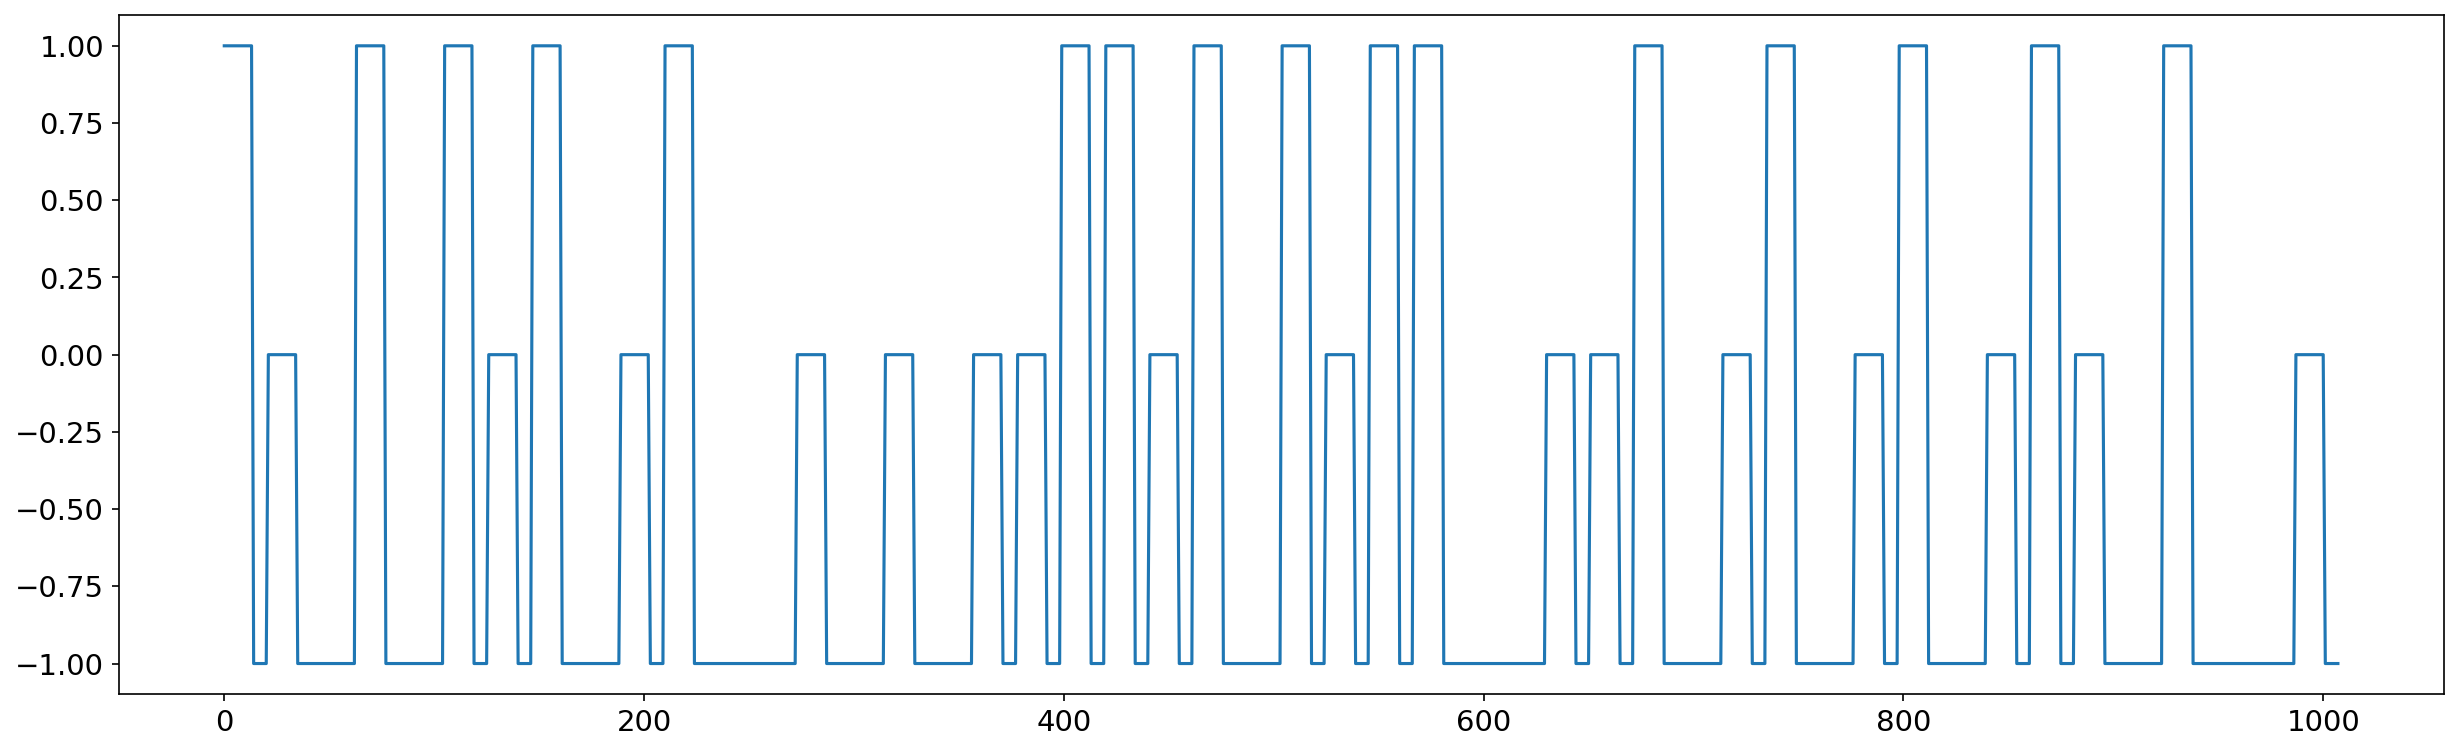

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6), dpi=150)

ax.plot(targets)